<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span><ul class="toc-item"><li><span><a href="#Resampling" data-toc-modified-id="Resampling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resampling</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Creating-Features" data-toc-modified-id="Creating-Features-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Creating Features</a></span></li><li><span><a href="#Train,-Valid,-Test" data-toc-modified-id="Train,-Valid,-Test-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train, Valid, Test</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#LinearRegression()" data-toc-modified-id="LinearRegression()-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression()</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#CatBoostRegressor()" data-toc-modified-id="CatBoostRegressor()-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor()</a></span></li></ul></li><li><span><a href="#Test" data-toc-modified-id="Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test</a></span></li></ul></div>

# Forecasting taxi orders

The taxi company collected historical data on taxi bookings at airports. To attract more drivers during peak periods, you need to predict the number of taxi orders for the next hour. Build a model to make this prediction.

The value of the *RMSE* metric on the test sample should be no more than 48.

You need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on a test sample and draw conclusions.


The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column (from the English *number of orders*, “number of orders”).

## Preparation

In [29]:
# !pip install --upgrade pandas
# !pip install --upgrade dask

In [30]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings

In [31]:
state = 42

In [32]:
try:
    data = pd.read_csv(r"C:\Users\olga.poletkina\OneDrive - HPP Architekten GmbH\GitHub\Practicum_Data_Science\datasets\taxi.csv")
except:
    data = pd.read_csv('/datasets/taxi.csv')

In [33]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [35]:
data.isna().sum().sum()

0

In [36]:
data.duplicated().sum()

0

In [37]:
data.datetime = pd.to_datetime(data.datetime)

In [38]:
data.set_index('datetime', inplace=True)

The data has been checked, no omissions or duplicates have been identified, the table has been brought into working form.

### Resampling

In [39]:
data = data.resample('1H').sum()

We resample (group) the data by one hour and calculate the total amount of taxis in a given period of time.

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Analysis

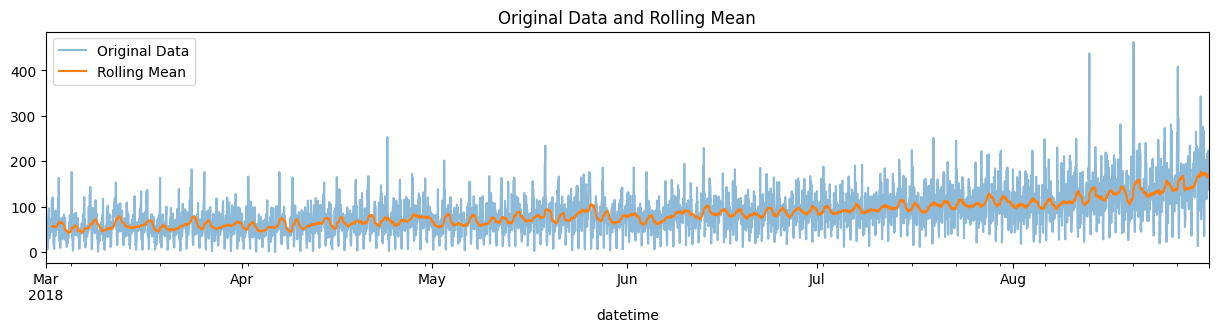

In [41]:
fig, ax = plt.subplots(figsize=(15, 3))
data.plot(ax=ax, alpha=0.5)
data.rolling(24).mean().plot(ax=ax)
plt.title('Original Data and Rolling Mean')
legend = ax.legend(['Original Data', 'Rolling Mean'])

On the graph, the blue color shows the time series, and the orange shows the moving average. The selected window size is 24 hours. The moving average shows the overall increase in the number of cars between March and September.

In [42]:
decomposed = seasonal_decompose(data) 

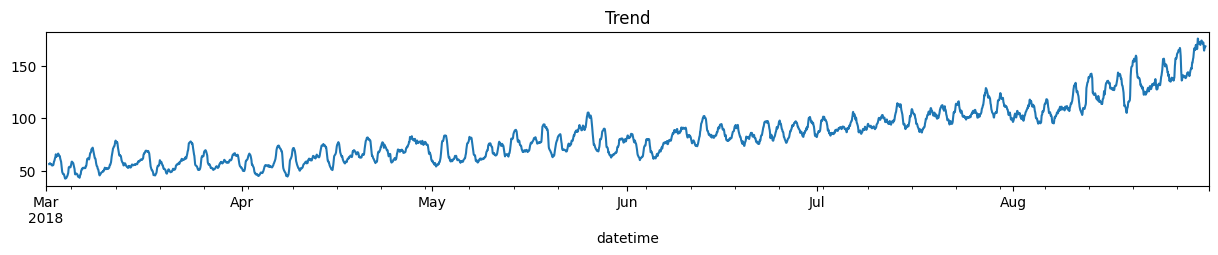

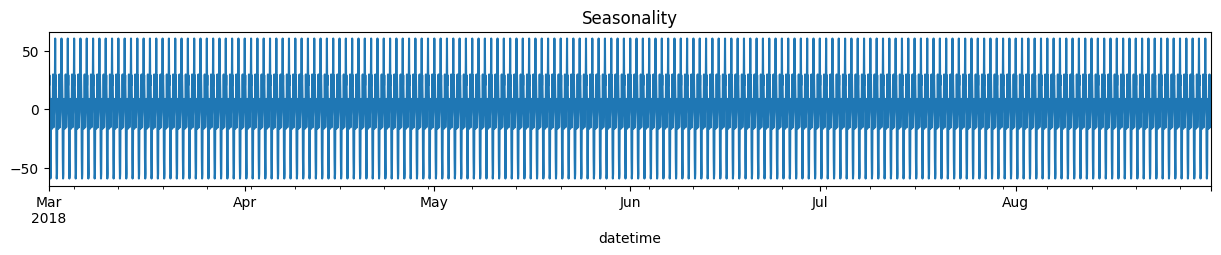

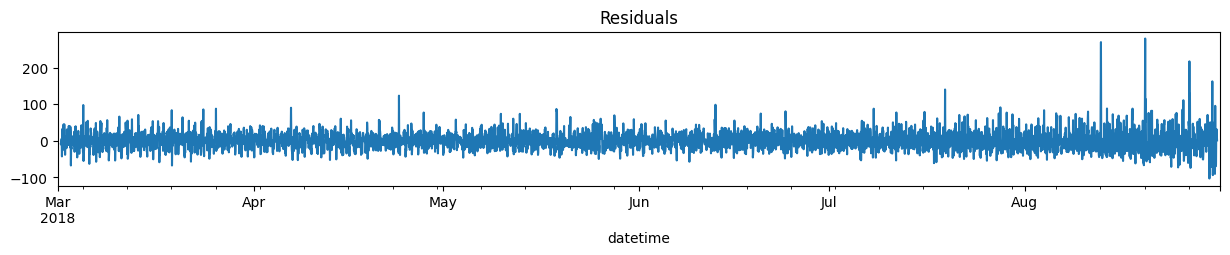

In [43]:
decomposed.trend.plot(ax=plt.gca(), figsize=(15,2))
plt.title('Trend')
plt.show()
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15,2))
plt.title('Seasonality')
plt.show()
decomposed.resid.plot(ax=plt.gca(), figsize=(15,2)) 
plt.title('Residuals')
plt.show()

- Using the trend graph, you can once again trace the smooth change in the average value, which shows an increase in the number of taxis in the period from March to September.
- Residuals graph is noise that is not explained by trend and seasonality. High noise peaks occur in the month of August.
- “Seasonality” graph – cyclically repeating patterns in a time series, let’s look at a shorter period below.

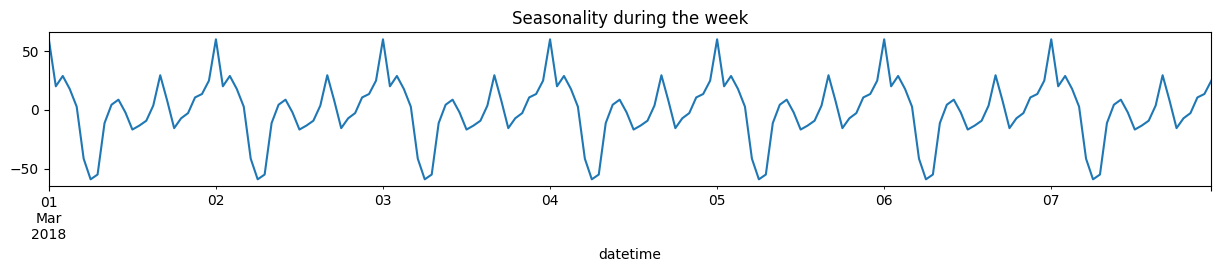

In [44]:
decomposed.seasonal['2018-03-01 ': '2018-03-07'].plot(figsize=(15,2))
plt.title('Seasonality during the week');

The “seasonality” graph shows the pattern of changes in the number of taxis during the day.

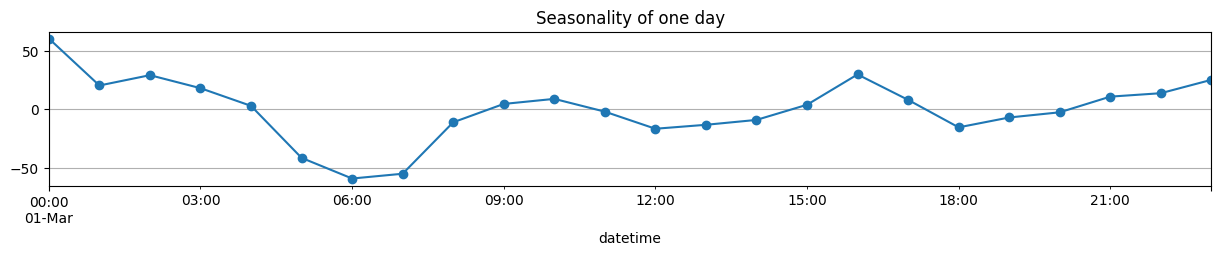

In [45]:
decomposed.seasonal['2018-03-01'].plot(figsize=(15,2), grid=True, style='o-')
plt.title('Seasonality of one day');

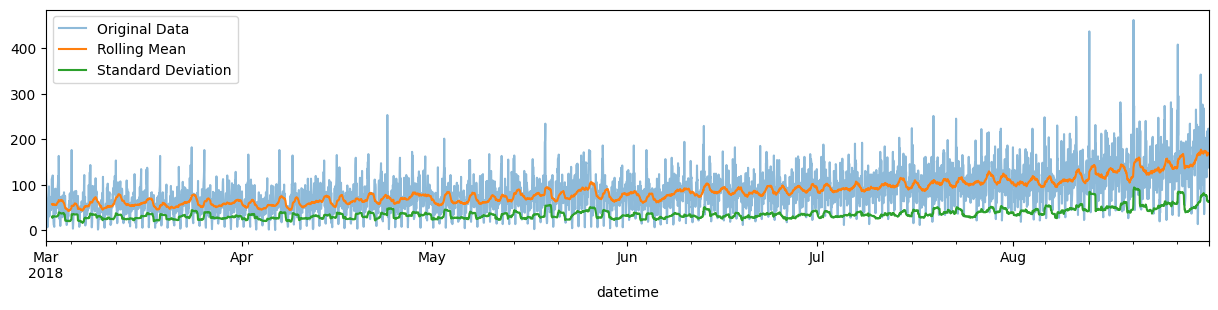

In [46]:
fig, ax = plt.subplots(figsize=(15, 3))
data.plot(ax=ax, alpha=0.5)
data.rolling(24).mean().plot(ax=ax)
data.rolling(24).std().plot(ax=ax)
legend = ax.legend(['Original Data', 'Rolling Mean', 'Standard Deviation']);

Changes in the mean and standard deviation show that the time series presented in the graph is non-stationary.

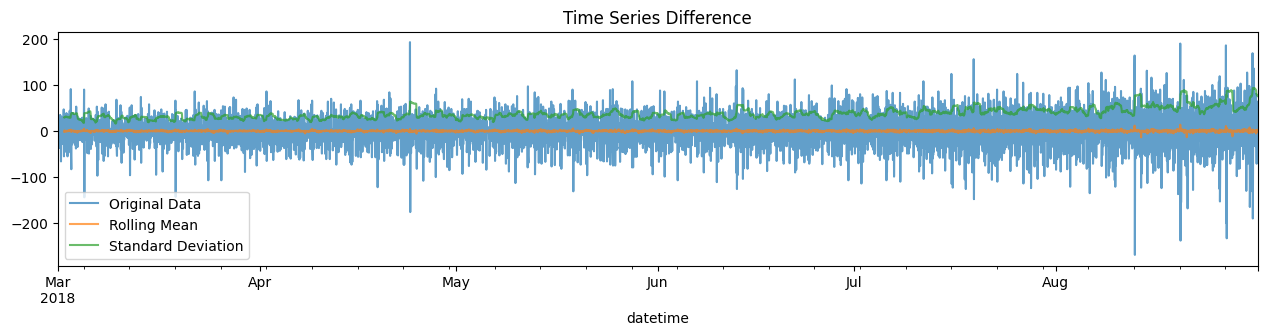

In [47]:
data_shift = data - data.shift()
# data_shift
data_shift['Rolling Mean'] = data_shift['num_orders'].rolling(24).mean()
data_shift['Standard Deviation'] = data_shift['num_orders'].rolling(24).std()
data_shift.plot(figsize=(15, 3), alpha=0.7)
plt.legend(['Original Data', 'Rolling Mean', 'Standard Deviation'], loc='lower left')
plt.title('Time Series Difference')
plt.subplots_adjust(left=0.1, bottom=0.1)
plt.show()

The time series difference graph, which shows the differences between adjacent table elements, shows that the data and the mean have become more stationary and are now easier to predict.

### Creating Features

Selecting signs:

- There is daily “seasonality”, we use the day attribute.
- You can see a different distribution of quantities depending on the day of the week; we use the dayofweek attribute.
- Data changes depending on the month, let's create a month attribute.
- We also include hourly data in the signs, since the forecast is made for an hour.

In [48]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [49]:
warnings.filterwarnings("ignore")

data_new = make_features(data, 168, 24)

In [50]:
data_new = data_new.dropna()
data_new.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,3,0,94.0,127.0,108.0,76.0,50.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,78,3,8,3,1,143.0,94.0,127.0,108.0,76.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,65,3,8,3,2,78.0,143.0,94.0,127.0,108.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,68,3,8,3,3,65.0,78.0,143.0,94.0,127.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,60,3,8,3,4,68.0,65.0,78.0,143.0,94.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333


In [51]:
data_new.isna().sum()

num_orders      0
month           0
day             0
dayofweek       0
hour            0
               ..
lag_165         0
lag_166         0
lag_167         0
lag_168         0
rolling_mean    0
Length: 174, dtype: int64

### Train, Valid, Test

In [52]:
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train, valid = train_test_split(train, shuffle=False, test_size=0.2)

y_train = train['num_orders']
y_test = test['num_orders']
y_valid = valid['num_orders']

X_train = train.drop(columns='num_orders')
X_test = test.drop(columns='num_orders')
X_valid = valid.drop(columns='num_orders')

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(3058, 173)
(765, 173)
(425, 173)
(3058,)
(765,)
(425,)


## Training

### LinearRegression()

Best parameters: {'fit_intercept': True}
RMSE of training set for LinearRegression: 18.620650240633495
RMSE of validation set for LinearRegression:  27.536534751247313
CPU times: total: 1.03 s
Wall time: 822 ms


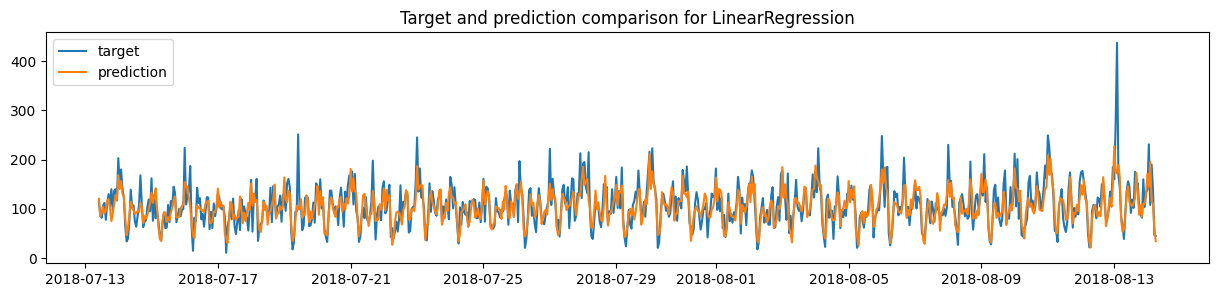

In [54]:
%%time

model_lr = LinearRegression()

parameters = {'fit_intercept': [True, False]}

grid_search = GridSearchCV(model_lr, parameters)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

model_lr.set_params(**best_params)

model_lr.fit(X_train, y_train)
predictions_train = model_lr.predict(X_train)
predictions_valid = model_lr.predict(X_valid)

rmse_train_lr = mean_squared_error(y_train, predictions_train, squared=False)
rmse_valid_lr = mean_squared_error(y_valid, predictions_valid, squared=False)

print("Best parameters:", best_params)
print("RMSE of training set for LinearRegression:", rmse_train_lr)
print("RMSE of validation set for LinearRegression: ", rmse_valid_lr)

plt.figure(figsize=(15, 3))
plt.plot(y_valid.index.tolist(), y_valid.tolist(), label='target')
plt.plot(y_valid.index.tolist(), predictions_valid.tolist(), label='predicted')
plt.title('Target and prediction comparison for LinearRegression')
plt.legend(['target', 'prediction'])


### Lasso

Best parameters: {'alpha': 1.0}
RMSE training set for Lasso: 18.674655865607463
RMSE of validation set for Lasso:  27.303816253023058
CPU times: total: 2.34 s
Wall time: 2.26 s


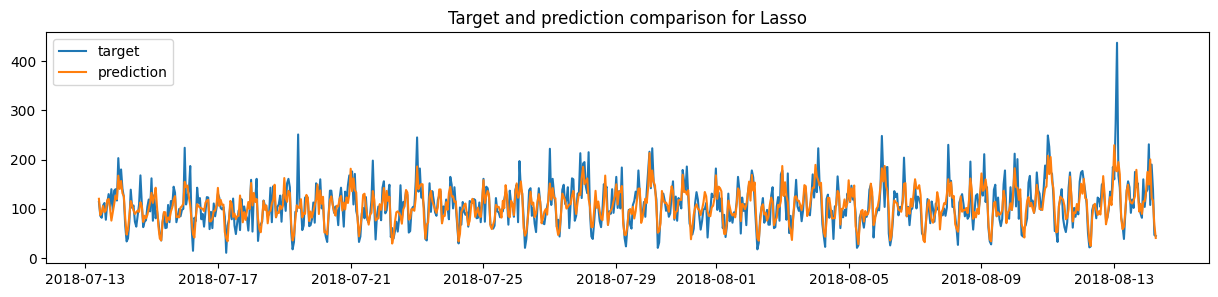

In [57]:
%%time

model_l = Lasso()

parameters = {'alpha': [0.1, 0.5, 1.0]}

grid_search = GridSearchCV(model_l, parameters)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

model_l.set_params(**best_params)

model_l.fit(X_train, y_train)
predictions_train = model_l.predict(X_train)
predictions_valid = model_l.predict(X_valid)

rmse_train_l = mean_squared_error(y_train, predictions_train, squared=False)
rmse_valid_l = mean_squared_error(y_valid, predictions_valid, squared=False)

print("Best parameters:", best_params)
print("RMSE training set for Lasso:", rmse_train_l)
print("RMSE of validation set for Lasso: ", rmse_valid_l)

plt.figure(figsize=(15, 3))
plt.plot(y_valid.index.tolist(), y_valid.tolist(), label='target')
plt.plot(y_valid.index.tolist(), predictions_valid.tolist(), label='predicted')
plt.title('Target and prediction comparison for Lasso')
plt.legend(['target', 'prediction'])

### Ridge

Best parameters: {'alpha': 1.0}
RMSE of training set for Ridge: 18.620650698908868
RMSE of the validation set for Ridge:  27.535608410802254
CPU times: total: 516 ms
Wall time: 425 ms


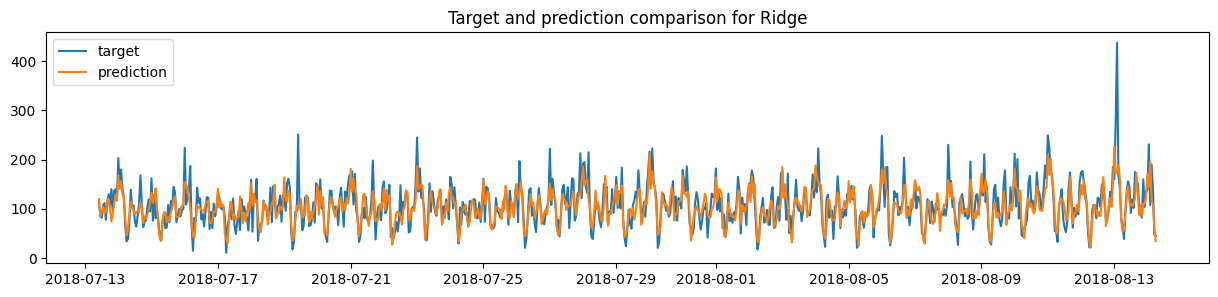

In [60]:
%%time

model_r = Ridge()

parameters = {'alpha': [0.1, 0.5, 1.0]}

grid_search = GridSearchCV(model_r, parameters)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

model_r.set_params(**best_params)

model_r.fit(X_train, y_train)
predictions_train = model_r.predict(X_train)
predictions_valid = model_r.predict(X_valid)

rmse_train_r = mean_squared_error(y_train, predictions_train, squared=False)
rmse_valid_r = mean_squared_error(y_valid, predictions_valid, squared=False)

print("Best parameters:", best_params)
print("RMSE of training set for Ridge:", rmse_train_r)
print("RMSE of the validation set for Ridge: ", rmse_valid_r)

plt.figure(figsize=(15, 3))
plt.plot(y_valid.index.tolist(), y_valid.tolist(), label='target')
plt.plot(y_valid.index.tolist(), predictions_valid.tolist(), label='predicted')
plt.title('Target and prediction comparison for Ridge')
plt.legend(['target', 'prediction'])

### CatBoostRegressor()

0:	learn: 33.6700781	test: 52.2589179	best: 52.2589179 (0)	total: 162ms	remaining: 2m 41s
999:	learn: 10.5666239	test: 29.2458841	best: 28.6259667 (241)	total: 6.04s	remaining: 0us

bestTest = 28.62596674
bestIteration = 241

Shrink model to first 242 iterations.
0:	learn: 33.7396575	test: 52.8999717	best: 52.8999717 (0)	total: 6.58ms	remaining: 6.58s
999:	learn: 10.6098213	test: 29.5188176	best: 28.6570416 (363)	total: 6.01s	remaining: 0us

bestTest = 28.65704163
bestIteration = 363

Shrink model to first 364 iterations.
0:	learn: 33.6826196	test: 54.1731825	best: 54.1731825 (0)	total: 7.02ms	remaining: 7.02s
999:	learn: 10.0665562	test: 29.1046585	best: 28.8578025 (377)	total: 6.29s	remaining: 0us

bestTest = 28.85780253
bestIteration = 377

Shrink model to first 378 iterations.
0:	learn: 33.2345768	test: 55.5575376	best: 55.5575376 (0)	total: 7.2ms	remaining: 7.2s
999:	learn: 9.8547192	test: 30.5186734	best: 29.2877640 (193)	total: 6.06s	remaining: 0us

bestTest = 29.28776405
bestIt

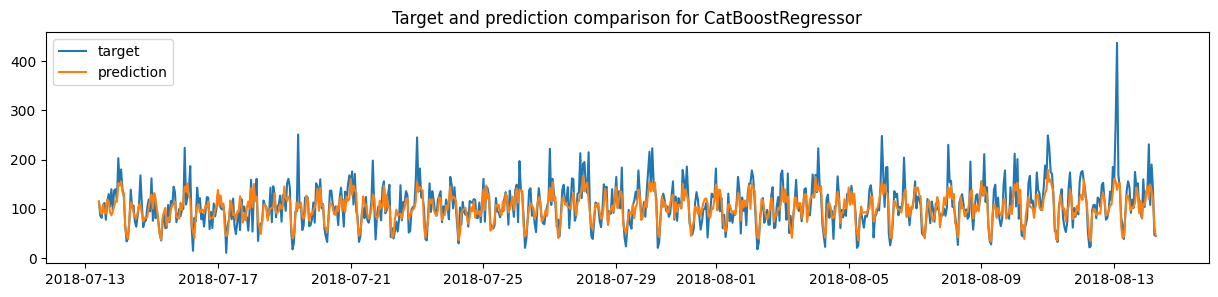

In [61]:
%%time

parameters = {'max_depth': [4, 6],
              'learning_rate': [0.05, 0.1]}

model_cbr = CatBoostRegressor(task_type='CPU', loss_function='RMSE', random_seed=state, verbose=1000)
grid_search = GridSearchCV(model_cbr, parameters)

grid_search.fit(X_train, y_train, eval_set=(X_valid, y_valid))

best_params = grid_search.best_params_

model_cbr.set_params(**best_params)

model_cbr.fit(X_train, y_train, eval_set=(X_valid, y_valid))
predictions_train = model_cbr.predict(X_train)
predictions_valid = model_cbr.predict(X_valid)

rmse_train_cbr = mean_squared_error(y_train, predictions_train, squared=False)
rmse_valid_cbr = mean_squared_error(y_valid, predictions_valid, squared=False)

print("Best parameters:", best_params)
print("RMSE training set for CatBoostRegressor:", rmse_train_cbr)
print("RMSE validation set for CatBoostRegressor: ", rmse_valid_cbr)

plt.figure(figsize=(15, 3))
plt.plot(y_valid.index.tolist(), y_valid.tolist(), label='target')
plt.plot(y_valid.index.tolist(), predictions_valid.tolist(), label='predicted')
plt.title('Target and prediction comparison for CatBoostRegressor')
plt.legend(['target', 'prediction'])

In [62]:
models = pd.DataFrame({
    'model': ['LinearRegression', 'Lasso', 'Ridge', 'CatBoostRegressor'],
    'RMSE val':[rmse_valid_lr, rmse_valid_l, rmse_valid_r, rmse_valid_cbr]
})

models

,model,RMSE val
0,LinearRegression,27.536535
1,Lasso,27.303816
2,Ridge,27.535608
3,CatBoostRegressor,28.298142


All models gave approximately the same result on the validation set, but for this type of problem on the test set, linear regression will most likely work better. Linear models have their advantages, especially when it comes to understanding trends in data. They assume linear relationships between input features and the target variable, which makes it possible to identify general trends and relationships.

## Test

Проверяем тестовую выборку на лучшей модели, которой оказалась Lasso

In [67]:
predictions_test_l = model_l.predict(X_test)
rmse_test_l = mean_squared_error(y_test, predictions_test_l, squared=False)
print("RMSE test sample for Lasso: ", rmse_test_l)

RMSE test sample for Lasso:  34.9174145308128


RMSE on the test sample satisfies the condition <48

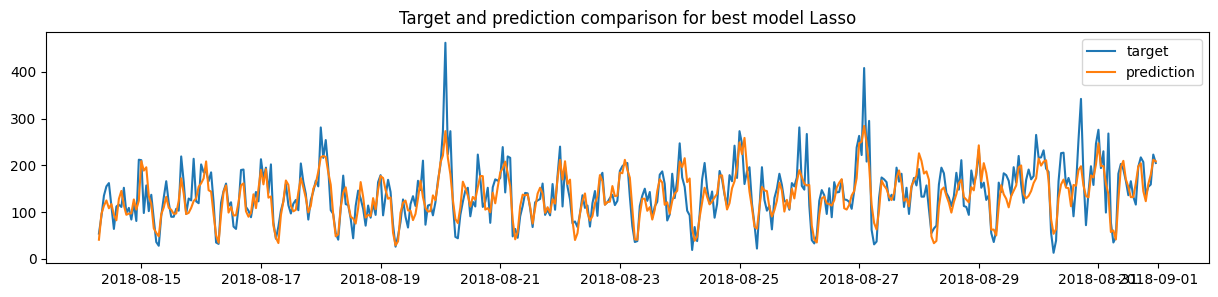

In [68]:
plt.figure(figsize=(15, 3))
plt.plot(y_test.index.tolist(), y_test.tolist(), label='target')
plt.plot(y_test.index.tolist(), predictions_test_l.tolist(), label='predicted')
plt.title('Target and prediction comparison for best model Lasso')
plt.legend(['target', 'prediction']);

The best model that showed the best RMSE metric on the validation set = 27.30 and on the test set = 34.92 is Lasso